# Statistics and Inverse Problems 2025
## Exercise 2 - Linear Tomography

### Author(s), contact(s), and dates:
- Author: Valentina Espinoza Fernández (University of Copenhagen), Klaus Mosegaard (Niels Bohr Institute)
- Email:  vf@ign.ku.dk
- Date:   9th of January 2025

# Tabel of contents
* [Problem setup](#problem-setup)
* [The Forward Problem](#forward-problem)
* [The Inverse Problem](#inverse-problem)
* [MonteCarlo Simulation](#monte-carlo)

In this notebook we will look into the anomalies induced by an heterogenous Earth, particularly in the time-arrival of seismic waves. For this exercise we are given knowledge of the subsurface wave propagation velocity, but not the rays time-arrival anomalies, which would normally constitute our observations (data). We will pose the forward problem to simulate the arrival delays on 10 seismographs, and then feed back this data to reconstruct the velocity grid in the subsurface. 

In [200]:
# Public dependencies
import numpy as np
import matplotlib.pyplot as plt

# Local dependencies - YOUR COMPUTER
from DEPENDENCIES.e2_dependencies import add_colorbar, plot_grid, plot_path_arrows, plot_stations, set_figure
from DEPENDENCIES.inverse_dependencies import find_optimal_epsilon, lsqr_solution

## Problem Setup <a  class="anchor" id="problem-setup"></a>

We shall analyze first-arrivals of seismic waves from two earthquakes, recorded by 10 seismographs at the earth's surface. Rays hit the seismographs with an angle of
incidence of 45 degrees; rays from earthquake 1 come from the left, and rays from earthquake 2 come from right.

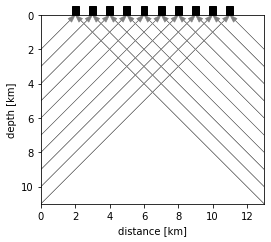

In [201]:
# Plot ray paths and stations
fig, ax = plt.subplots(figsize=(4,4))
plot_path_arrows(ax, color='grey')       # Plot the ray paths
plot_stations(ax)                        # Plot the seismograph stations
set_figure(ax)                           # Polish the profile figure

 We will consider a 13 x 11 km vertical cross section of the subsurface, located immediately below 10 seismographs. Inside this cross section, the wave propagation velocity is 5000 m/s (`v_out`), except in a rectangular zone, where the velocity is 5200 m/s (`v_rect`). The presence of this zone introduces an arrival-time anomaly (a deviation of the arrival time from a situation where the entire area is homogeneous).

In [202]:
# Some model parameters

v_out = 5000         # seismic wave propagation velocity outside the rectangle [m/s]
v_rect = 5200        # seismic wave propagation velocity inside the rectangle [m/s]
n_seis = 10          # number of seismograms/rays per earthquake

In [203]:
# Velocity matrix setup
vel_grid = np.ones((11, 13))      # Create a matrix of size 11x13 of ones
vel_grid = vel_grid * v_out       # Set the value of all grid cells to 5000 [m/s]
vel_grid[1:9, 4:7] = v_rect       # Modify the values between depth 1 to 9 (rows 1-8) and distance 4 to 6 (columns 4-5) to 5200 [m/s]

# Slowness matrix setup 
s_anom_grid = vel_grid**(-1) - 1/v_out      # Set the value of all grid cells to the slowness anomaly based on the corresponding cell in the velocity grid

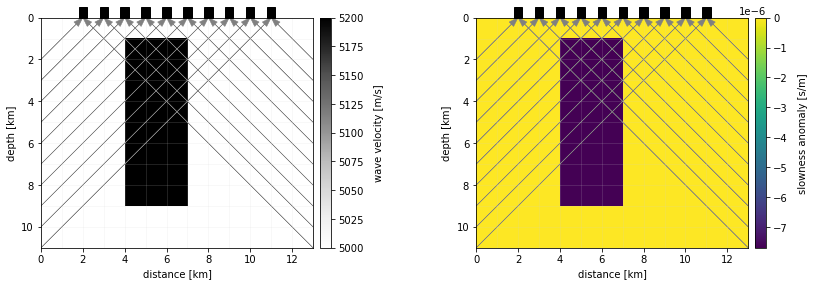

In [204]:
# Plot problem

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6), gridspec_kw={"wspace":0.5})

# Plot the velocity grid
im = ax1.imshow(vel_grid, extent=(0, 13, 11, 0), cmap="Greys")    # Plot velocity matrix grid
add_colorbar(fig, ax1, label='wave velocity [m/s]', image=im)     # Add the grid's colorbar
plot_path_arrows(ax1, color='grey')                               # Plot the ray paths
plot_grid(ax1, alpha=0.3)                                         # Plot grid lines
plot_stations(ax1)                                                # Plot the seismograph stations
set_figure(ax1) 

# Plot the velocity anomaly grid
im = ax2.imshow(s_anom_grid, extent=(0, 13, 11, 0))               # Plot velocity matrix grid
add_colorbar(fig, ax2, label='slowness anomaly [s/m]', image=im)  # Add the grid's colorbar
plot_path_arrows(ax2, color='grey')                               # Plot the ray paths
plot_grid(ax2, alpha=0.3)                                         # Plot grid lines
plot_stations(ax2)                                                # Plot the seismograph stations
set_figure(ax2) 

The equation for the time arrival anomaly $t_\gamma$ for a wave propagating along a ray $\gamma$, is given by:

$$ t_\gamma = \int_{\gamma} s(u) du$$

where $s(u)$ is the slowness anomaly along the ray, and $u$ is a parameter determining the point we consider on the ray.

By discretizing into grid cells, the equation can be written as:

$$ t_\gamma = \sum_{i=1}^{n_{model}} s(u_i) \cdot d_{cell}$$

where $n_{model}$ in the number of model parameters and $d_{cell}$ is the distance traveled within each cell. 

In [205]:
n_model = 13 * 11                     # number of model parameters
distance_cell = np.sqrt(2) * 1000     # distance [m] traveled by a ray in each cell, here the diagonal of a 1x1 km cell

With these considerations, what can you say about the following questions:

1. Is the problem unique?
2. Is the problem linear?

## The Forward Problem <a  class="anchor" id="forward-problem"></a>

Then, $\mathbf{d}$ must be a vector of 20 elements, one for each arrival time anomaly of the 20 rays (ten seismographs, two earthquakes). $\mathbf{m}$ must be a vector of 143 elements with the velocity anomaly for each cell of the grid. Matrix $\mathbf{G}$ must make the conversion between both vectors, and therefore will have a 143 x 20 size.

In [206]:
# Construct the model parameters m vector
m_true = s_anom_grid.flatten()                # Flatten the matrix 11x13 to a 143x vector [you can check the shape of variable with e.g. np.shape()]

In [207]:
# Function to assign distance_cell values to the cells through which a given ray (i_ray) passes, other cell remain at zero

def ray_path(i_ray):                        
    
    path_vector = np.zeros(n_model)
    
    if i_ray < 10:
        n_ray = i_ray + 2
    
        for i in range(n_ray):
            path_vector[i_ray + 1 + i*12] = distance_cell
                
    else:
        n_ray = 21 - i_ray
        for i in range(n_ray):
            path_vector[i_ray - 8 + i*14] = distance_cell
        
    return path_vector

In [208]:
G = np.zeros((n_seis*2, n_model))    # Create a matrix of size 20x143 of zeros

for i in range(n_seis*2):                # Process all 20 ray paths
    G[i] = ray_path(i)

Constructing the observables vector $\mathbf{d_{true}} $ (where $\mathbf{d_{true}} = \mathbf{G}\mathbf{m} $)


In [209]:
# Calculate the true data d vector 

d_true = np.dot(G, m_true)

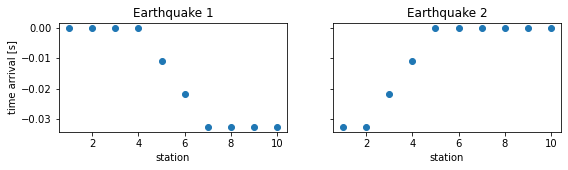

In [210]:
# Plot the time-arrival result for each earthqueake

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2), sharey=True)

ax1.plot(np.arange(1, 11), d_true[:10], 'o')
ax2.plot(np.arange(1, 11), d_true[10:], 'o')

ax1.set(xlabel="station", ylabel="time arrival [s]", title="Earthquake 1")
ax2.set(xlabel="station", title="Earthquake 2");

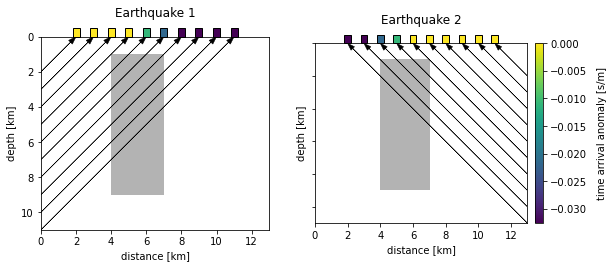

In [211]:
# Plot the time-arrival result for each earthquake on a profile

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Earthquake 1
ax1.imshow(vel_grid, extent=(0, 13, 11, 0), alpha=0.3, cmap="Greys")
plot_path_arrows(ax1, range=[0, 9])
cmap, norm = plot_stations(ax1, values=d_true[:10])
ax1.set_title("Earthquake 1", pad=20)
set_figure(ax1) 

# Earthquake 2
ax2.imshow(vel_grid, extent=(0, 13, 11, 0), alpha=0.3, cmap="Greys")
plot_path_arrows(ax2, range=[10, 19])
plot_stations(ax2, values=d_true[10:])
add_colorbar(fig, ax2, label="time arrival anomaly [s/m]", cmap_norm=[cmap, norm])
ax2.set_title("Earthquake 2", pad=20)
set_figure(ax2) 

## The Inverse Problem <a  class="anchor" id="inverse-problem"></a>

We define $\mathbf{d_{obs}}$ by adding noise (n) to the "true" data observed.
$$d_{obs} = d_{pure} + n $$

This noise will be added according to a Gaussian distribution with standard deviation 0.001.

In [212]:
n_mean = 0.0    # Noise distribution parameters
n_stg = 0.001

n =  np.random.normal(loc=n_mean, scale=n_stg, size=len(d_true))   # Create random values according to a normal distribution to add to our data
noise_norm = np.linalg.norm(n)

d_obs = d_true + n

#### Find a solution to the inverse problem

The estimated solution ($\mathbf{m}^{est}$) to this problem can be formulated with the *Tikhonov Regularization* method.

$$\boxed{ \mathbf{m}^{est} = \left[\mathbf{G}^T \mathbf{G} + \epsilon^2 \mathbf{I}\right]^{-1} \mathbf{G}^T \mathbf{d}^{obs}  }$$

This calculation can be handled with our custom function `lsqr_solution`. But we do need to find a suitable value for $\epsilon$, which we can do so by passing a testing range of epsilons value to the custom function `find_optimal_epsilon`. This means, find an epsilon that *barely fits the data whithin the noise level*, in order to avoid overfitting.

All what is left to do is find the model $\mathbf{m}$ parameter values, based on the forward-constructed $\mathbf{G}$ matrix, the noisy observed data $\mathbf{d_{obs}}$, and the chosen epsilon value $\mathbf{\epsilon}$.

In [213]:
# Estimate optimal epsilon value

epsilon_values = np.logspace(1, 4, 500)       # Create an ensemble of 500 potential epsilon values between 10^1 and 10^4
epsilon = find_optimal_epsilon(G, d_obs, epsilon_values, noise_norm)

In [214]:
m_est = lsqr_solution(G, d_obs, epsilon)

### Results

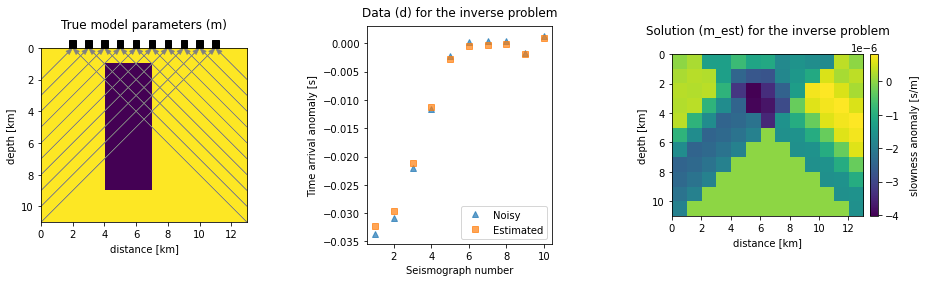

In [215]:
# Plot all results together

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"wspace": 0.6, "width_ratios": [1, 0.9, 1]})


# Plot anomalous area
ax1.imshow(s_anom_grid, extent=(0, 13, 11, 0))
plot_path_arrows(ax1, color="grey")
ax1.set_title("True model parameters (m)", pad=20)
plot_stations(ax1)
set_figure(ax1) 


# Plot the simulated data parameters
ax2.plot(np.arange(1, 11), d_obs[10:], '^', alpha=0.7, label="Noisy")
ax2.plot(np.arange(1, 11), np.dot(G[10:], m_est), 's', alpha=0.7, label="Estimated")
ax2.set(xlabel="Seismograph number", ylabel="Time arrival anomaly [s]")
ax2.set_title("Data (d) for the inverse problem", pad=10)
ax2.legend()


# Plot the model parameters
im = ax3.imshow(np.reshape(m_est, (11,13)), extent=(0, 13, 11, 0))
add_colorbar(fig, ax3, "slowness anomaly [s/m]", image=im)
ax3.set_title("Solution (m_est) for the inverse problem", pad=20)
set_figure(ax3)


Try tweking some parameters and see how the results change. 
1. Try setting the original velocity grid to an anomalous rectangle of different size. For a small square try ` vel_grid[1:2, 8:9] = v_rect `. What would happen if the square was a little further down? Try ` vel_grid[4:5, 8:9] = v_rect `.	


2. Try changing the noise level to something more uncertain, e.g., by setting the standard deviation to 0.01 with `n_stg = 0.001`.

## Monte Carlo Simulation <a  class="anchor" id="monte-carlo"></a>

Above we tested one simulation for one iteration of a noisy data. To test the full range of uncertainty in the data, we can perform a Monte Carlo exploration of the solution, by assigned a new random noise at each iteration of the loop.

In [216]:
n_simulations = 1000
m_est_array = np.zeros((11*13, n_simulations))
d_est_array = np.zeros((20, n_simulations))

for i in range(n_simulations):
    
    # Add random noise to the data
    n = np.random.normal(loc=n_mean, scale=n_stg, size=len(d_true))
    d_obs = d_true + n
    
    # Store simulated data and model parameters
    m_est_array[:, i] = lsqr_solution(G, d_obs, epsilon)   # No need to re-estimate epsilon
    d_est_array[:, i] = np.dot(G, m_est_array[:, i])

In [217]:
# Retrieve the mean for the simulated data and model parameters to plot

d_est_mean = [np.mean(d_est_array[i, :]) for i in range(20)]
d_est_std = [np.std(d_est_array[i, :]) for i in range(20)]
m_est_mean = [np.mean(m_est_array[i, :]) for i in range(143)]

### Results Summary

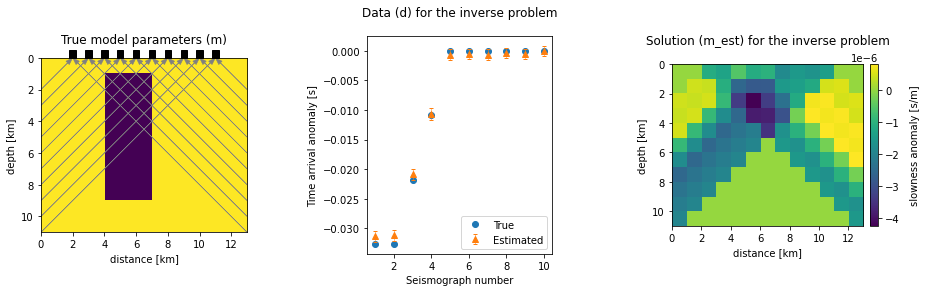

In [222]:
# Plot all results together

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={"wspace": 0.6, "width_ratios": [1, 0.9, 1]})


# Plot anomalous area
ax1.imshow(s_anom_grid, extent=(0, 13, 11, 0))     
plot_path_arrows(ax1, color="grey")
ax1.set_title("True model parameters (m)", pad=15)
plot_stations(ax1)
set_figure(ax1) 


# Plot the simulated data parameters
ax2.plot(np.arange(1, 11), d_true[10:], 'o', label="True")
ax2.errorbar(np.arange(1, 11), d_est_mean[10:], yerr=d_est_std[10:], capsize=2, fmt="^", elinewidth=0.5, label="Estimated")
ax2.set(xlabel="Seismograph number", ylabel="Time arrival anomaly [s]")
ax2.set_title("Data (d) for the inverse problem", pad=20)
ax2.legend()


# Plot the model parameters
im = ax3.imshow(np.reshape(m_est_mean, (11,13)), extent=(0, 13, 11, 0))
add_colorbar(fig, ax3, "slowness anomaly [s/m]", image=im)
ax3.set_title("Solution (m_est) for the inverse problem", pad=20)
set_figure(ax3)